# Import libraries

In [3]:
%reload_ext autoreload
%autoreload 2
import json
import re
from datetime import datetime
from pathlib import Path

import matplotlib as mpl
import numpy as np
import pandas as pd
import pycountry
from unidecode import unidecode

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
mpl.rcParams["figure.dpi"] = 300

# Import raw data

In [4]:
# Set up directories
BASE_DIR: Path = Path().resolve().parent
DATA_DIR: Path = BASE_DIR / "data"
RAW_DATA_DIR: Path = DATA_DIR / "raw"


# Load data
file_path_in: Path = RAW_DATA_DIR / "25072024_reviews.csv"
if not file_path_in.exists():
    raise FileNotFoundError(f"File {file_path_in} not found.")

df_in: pd.DataFrame = pd.read_csv(file_path_in)
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   rating                             7890 non-null   object 
 1   roaster                            7890 non-null   object 
 2   title                              7890 non-null   object 
 3   blind_assessment                   7889 non-null   object 
 4   notes                              7888 non-null   object 
 5   bottom_line                        3812 non-null   object 
 6   roaster location                   7887 non-null   object 
 7   coffee origin                      7386 non-null   object 
 8   roast level                        7488 non-null   object 
 9   agtron                             7890 non-null   object 
 10  est. price                         5852 non-null   object 
 11  review date                        7890 non-null   objec

# Initial Cleanup

In [43]:
# Cleanup column names
df_in.columns = (
    df_in.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(".", "")
)

df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rating                            7890 non-null   object 
 1   roaster                           7890 non-null   object 
 2   title                             7890 non-null   object 
 3   blind_assessment                  7889 non-null   object 
 4   notes                             7888 non-null   object 
 5   bottom_line                       3812 non-null   object 
 6   roaster_location                  7887 non-null   object 
 7   coffee_origin                     7386 non-null   object 
 8   roast_level                       7488 non-null   object 
 9   agtron                            7890 non-null   object 
 10  est_price                         5852 non-null   object 
 11  review_date                       7890 non-null   object 
 12  aroma 

In [44]:
def tweak_df(df: pd.DataFrame) -> pd.DataFrame:
    """Initial data cleaning"""
    strings_to_nan = ["", "NR", "N/A", "na", "NA"]
    return (
        df.map(lambda x: x.strip() if isinstance(x, str) else x)
        .assign(
            review_date=lambda df_: pd.to_datetime(df_["review_date"], format="%B %Y"),
            # Combine acidity and acidity/structure into one column
            acidity=lambda df_: pd.to_numeric(
                df_["acidity"].fillna(df_["acidity/structure"]), errors="coerce"
            ),
            # Split the agtron column into external and ground
            agtron_external=lambda df_: pd.to_numeric(
                df_["agtron"].str.split("/", expand=True)[0].str.strip(),
                errors="coerce",
            ).where(lambda x: x <= 100),
            agtron_ground=lambda df_: pd.to_numeric(
                df_["agtron"].str.split("/", expand=True)[1].str.strip(),
                errors="coerce",
            ).where(lambda x: x <= 100),
            # Flag espresso roasts
            is_espresso=lambda df_: (
                df_["title"].str.contains("espresso", case=False, na=False)
                | df_["with_milk"].notnull()
            ),
        )
        .replace(strings_to_nan, np.nan)
        .drop(
            columns=["acidity/structure", "agtron", "refresh(enable_javascript_first)"]
        )
        .astype(
            {
                k: "float"
                for k in [
                    "acidity",
                    "rating",
                    "aroma",
                    "body",
                    "flavor",
                    "aftertaste",
                ]
            }
        )
    )


df: pd.DataFrame = tweak_df(df_in)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rating            7886 non-null   float64       
 1   roaster           7890 non-null   object        
 2   title             7890 non-null   object        
 3   blind_assessment  7889 non-null   object        
 4   notes             7888 non-null   object        
 5   bottom_line       3812 non-null   object        
 6   roaster_location  7887 non-null   object        
 7   coffee_origin     7386 non-null   object        
 8   roast_level       7488 non-null   object        
 9   est_price         5852 non-null   object        
 10  review_date       7890 non-null   datetime64[ns]
 11  aroma             7829 non-null   float64       
 12  acidity           6611 non-null   float64       
 13  body              7878 non-null   float64       
 14  flavor            7873 n

# Price and Quantity Cleaning

## Cleaning quantities

In [91]:
# Defining list of quantity terms to drop from the dataset
drop_terms: list[str] = [
    r"\bcan(?:s)?\b",
    r"\bbox(?:es|ed)?\b",
    r"\bcapsule(?:s)?\b",
    r"\bK-\b",
    r"\bflask(?:s)?\b",
    r"\bcup(?:s)?\b",
    r"\bbag(?:s)?\b",
    r"\bconcentrate(?:s)?\b",
    r"\bdisc(?:s)?\b",
    r"\bbottle(?:s)?\b",
    r"\bpod(?:s)?\b",
    r"\bpouch(?:es)?\b",
    r"\bpacket(?:s)?\b",
    r"\btin(?:s)?\b",
    r"\binstant\b",
    r"\bsachet(?:s)?\b",
    r"\bvue\b",
    r"\bsingle-serve(?:s)?\b",
    r"\bfluid(?:s)?\b",
]
# Regex drop term string
drop_terms_string: str = r"|".join(drop_terms)

# Regex patterns
remove_parentheses_pattern: re.Pattern[str] = re.compile(r"\(.*?\)")
remove_notes_pattern: re.Pattern[str] = re.compile(r";.*")
remove_online_pattern: re.Pattern[str] = re.compile(r"online")
standardize_units_patterns: list[tuple[re.Pattern[str], str]] = [
    (re.compile(r"\bgrams"), "grams"),
    (re.compile(r"\bgram\b"), "grams"),
    (re.compile(r".g$"), " grams"),
    (re.compile(r"pound$"), "1 pounds"),
    (re.compile(r"oz|onces|ouncues|ounce$|ounces\*"), "ounces"),
    (re.compile(r"kilogram"), "kilograms"),
    (re.compile(r"kg"), "kilograms"),
    (re.compile(r"capsulte"), "capsule"),
]
number_pattern: re.Pattern[str] = re.compile(r"(\d+(?:\.\d+)?)")
currency_pattern: re.Pattern[str] = re.compile(r"(\d+\.\d+|\d+)")

# Final quantity units
allowed_quantity_units: list[str] = ["ounces", "pounds", "grams", "kilograms"]

In [107]:
def prep_quantity_column(column: pd.Series) -> pd.Series:
    return (
        column.str.lower()
        .str.strip()
        # Remove parentheses and notes
        .str.replace(remove_parentheses_pattern, "", regex=True)
        .str.replace(remove_notes_pattern, "", regex=True)
        # Clean and standardize quantity units
        .pipe(
            lambda s: s.replace(
                {pat: repl for pat, repl in standardize_units_patterns},
                regex=True,
            )
        )
        # Remove "online" from any quantity
        .str.replace(remove_online_pattern, "", regex=True)
        .str.strip()
    )


def prep_price_column(column: pd.Series) -> pd.Series:
    return column


def extract_quantity_value(column: pd.Series) -> pd.Series:
    return column.str.extract(number_pattern)


def extract_quantity_unit(column: pd.Series) -> pd.Series:
    return column


def extract_price_value(column: pd.Series) -> pd.Series:
    return column


def extract_price_currency(column: pd.Series) -> pd.Series:
    return column


def create_price_quantity_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Split the est_price column into price and quantity columns
    return (
        df.assign(
            # Split est_price into price and quantity, removing commas
            **df["est_price"]
            .str.split("/", n=1, expand=True)
            .replace(",", "", regex=True)
            .rename(columns={0: "price", 1: "quantity"})
        )
        # Filter out rows with unwanted terms in the quantity column
        .loc[
            lambda x: ~x["quantity"].str.contains(
                drop_terms_string, case=False, na=False
            ),
            :,
        ]
        .assign(
            quantity=lambda x: prep_quantity_column(x["quantity"]),
            price=lambda x: prep_price_column(x["price"]),
        )
        .assign(
            quantity_unit=lambda x: extract_quantity_unit(x["quantity"]),
            quantity_value=lambda x: extract_quantity_value(x["quantity"]),
            price_value=lambda x: extract_price_value(x["price"]),
            price_currency=lambda x: extract_price_currency(x["price"]),
        )
    )


df = df_in.pipe(tweak_df).pipe(create_price_quantity_columns)
df[["est_price", "price", "quantity", "quantity_value"]].sample(10)

,est_price,price,quantity,quantity_value
4277,NT $800/227 grams,NT $800,227 grams,227
2273,NaN,NaN,NaN,NaN
4794,$13.95/12 ounces,$13.95,12 ounces,12
7190,$17.50/12 ounces,$17.50,12 ounces,12
658,$20.00/12 ounces,$20.00,12 ounces,12
137,$22.00/16 ounces,$22.00,16 ounces,16
3661,$15.50/12 ounces,$15.50,12 ounces,12
3607,NaN,NaN,NaN,NaN
5558,NaN,NaN,NaN,NaN
3121,NaN,NaN,NaN,NaN


In [95]:
def create_price_quantity_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Split the est_price column into price and quantity columns"""
    price_quantity = (
        df
        # Split est_price into columns for price and quantity
        .est_price.str.split("/", n=1, expand=True)
        # Remove any commas from the price and quantity columns
        .replace(",", "", regex=True)
        .rename(columns={0: "price", 1: "quantity"})
        .assign(
            # Cleanup quantity column
            quantity=lambda df_: (
                df_["quantity"]
                .str.lower()
                .str.strip()
                # Remove parentheses and notes
                .str.replace(remove_parentheses_pattern, "", regex=True)
                .str.replace(remove_notes_pattern, "", regex=True)
                # Clean and standardize quantity units
                .pipe(
                    lambda s: s.replace(
                        {pat: repl for pat, repl in standardize_units_patterns},
                        regex=True,
                    )
                )
                # Remove "online" from any quantity
                .str.replace(remove_online_pattern, "", regex=True)
                .str.strip()
            ),
            # Cleanup typos multiple ... to . in price
            price=lambda df_: df_["price"].str.replace(r"\.\.+", ".", regex=True),
        )
        # Important to drop NA
        .dropna()
        .loc[
            lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),
            :,
        ]
        # Split quantity column into values and units
        # Split the price column into currency and amount
        .assign(
            # Extract number value from quantity
            quantity_value=lambda df_: (
                df_["quantity"].str.extract(number_pattern).astype(float)
            ),
            # Extract the unit from quantity column
            quantity_unit=lambda df_: (
                df_["quantity"]
                .str.replace(number_pattern, "", regex=True)
                .replace(r"\.", "", regex=True)
                .str.strip()
                .mask(lambda s: s == "g", "grams")
                .mask(lambda s: s == "kilo", "kilograms")
                .str.strip()
            ),
            # Extract price value from price column
            price_value=lambda df_: (
                df_["price"].str.extract(currency_pattern).astype(float)
            ),
            # Extract currency from price column
            price_currency=lambda df_: (
                df_["price"]
                .str.replace(",", "")
                .str.replace(currency_pattern, "", regex=True)
                .str.strip()
            ),
        )
        # Drop the original price and quantity columns
        .drop(columns=["price", "quantity"])
        # Final check, keep only unit columns that are in the allowed list
        .loc[lambda df_: df_["quantity_unit"].isin(allowed_quantity_units)]
    )
    return price_quantity


price_quantity_df = df_in.pipe(tweak_df).pipe(create_price_quantity_dataframe)
price_quantity_df.sample(10)

,quantity_value,quantity_unit,price_value,price_currency
7556,6.0,ounces,32.00,$
7083,14.0,ounces,16.99,$
6262,12.0,ounces,15.00,$
1307,500.0,grams,15.16,$
3537,12.0,ounces,18.95,$
5090,8.0,ounces,11.00,$
4387,250.0,grams,10000.00,KRW $
7860,12.0,ounces,19.00,$
6147,8.0,ounces,500.00,NT $
1329,250.0,grams,150.00,HK $


In [45]:
def create_price_quantity_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Merge price and quantity columns with original dataframe"""
    price_quantity = create_price_quantity_dataframe(df)
    return df.merge(price_quantity, how="left", left_index=True, right_index=True)


df = df_in.pipe(tweak_df).pipe(create_price_quantity_columns)


df.loc[
    df["est_price"] == "NT $520/200g",
    ["est_price", "quantity_value", "quantity_unit", "price_value", "price_currency"],
]

/var/folders/_b/62zrcmn50rvfx7ybj6pcf5380000gp/T/ipykernel_51059/3293390195.py:82: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),


,est_price,quantity_value,quantity_unit,price_value,price_currency
6437,NT $520/200g,20.0,grams,520.0,NT $


In [46]:
def convert_to_lbs(df: pd.DataFrame) -> pd.DataFrame:
    """Return dataframe with a new column convertign quantity into lbs"""
    convert_to_lbs_map: dict[str, float] = {
        "ounces": 1 / 16,
        "pounds": 1,
        "kilograms": 2.20462,
        "grams": 0.00220462,
    }

    df["quantity_in_lbs"] = np.round(
        df["quantity_value"] * df["quantity_unit"].map(convert_to_lbs_map), 3
    )
    return df


df = df_in.pipe(tweak_df).pipe(create_price_quantity_columns).pipe(convert_to_lbs)

df.groupby("quantity_unit")[
    ["est_price", "quantity_value", "quantity_unit", "quantity_in_lbs"]
].sample(1)

/var/folders/_b/62zrcmn50rvfx7ybj6pcf5380000gp/T/ipykernel_51059/3293390195.py:82: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),


,est_price,quantity_value,quantity_unit,quantity_in_lbs
1816,NT $250/227 grams,227.0,grams,0.500
6555,THB $600/1 kilogram,1.0,kilograms,2.205
614,$18.95/16 ounces,16.0,ounces,1.000
2846,$17.99/3 pounds,3.0,pounds,3.000


## Cleaning Prices and Currencies
Here we normalize the currency column to contain a standard set of ISO 4217 currency codes. This will help us with fetching exchange rates from an API later on.

In [13]:
def clean_currency(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize currencies to ISO 4217 codes."""
    currency_map = {
        "PRICE: $": "USD",
        "#": "GBP",
        "¥": "JPY",
        "£": "GBP",
        "€": "EUR",
        "POUND": "GBP",
        "PESOS": "COP",  # Only pesos are from colombian roasts so COP
        "RMB": "CNY",
        "EUROS": "EUR",
        "RM": "MYR",
    }
    price_currency = (
        df.price_currency.str.upper()
        .str.replace(r"^\$$", "USD", regex=True)
        .replace(currency_map, regex=False)
        .replace(r"\$", "", regex=True)
        .str.strip()
        .mask(lambda s: s == "US", "USD")
        .mask(lambda s: s == " ", "USD")
        .mask(lambda s: s == "E", "EUR")
        .mask(lambda s: s == "NTD", "TWD")
        .mask(lambda s: s == "NT", "TWD")
        .mask(lambda s: s == "", "USD")
        .mask(lambda s: s == "HK", "HKD")
        .str.strip()
    )
    return df.assign(price_currency=price_currency)


df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(convert_to_lbs)
    .pipe(clean_currency)
)

# Check that currencies make sense from original est_price column
df.loc[
    :, ["est_price", "price_currency", "price_value", "title", "coffee_origin"]
].groupby(
    "price_currency",
).sample(3, replace=True)

/var/folders/_b/62zrcmn50rvfx7ybj6pcf5380000gp/T/ipykernel_51059/2709149053.py:82: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),


,est_price,price_currency,price_value,title,coffee_origin
1462,AED $103.95/250 grams,AED,103.95,Ethiopia Guji Girma Natural,"Guji Zone, southern Ethiopia"
1462,AED $103.95/250 grams,AED,103.95,Ethiopia Guji Girma Natural,"Guji Zone, southern Ethiopia"
7560,AED $99.75/250 grams,AED,99.75,Ethiopia Kayon Mountain,"Odo Shakiso District, Guji Zone, southern Ethiopia"
7640,AUD $48.00/200 grams,AUD,48.00,Geisha Panama Santamaria Natural,"Paso Ancho, Volcan, western Panama"
1030,AUD $16.00/250 grams,AUD,16.00,Hernando Chantre Colombia,"Huila Department, southern Colombia"
7827,AUD $18.00/18 grams,AUD,18.00,Panama Hacienda La Esmeralda Super Mario Geisha,"Boquete growing region, western Panama"
5621,CAD $17.00 / 16 oz.,CAD,17.00,El Salvador Finca Alaska,"Santa Ana Department, El Salvador."
3627,CAD $17.78/12 ounces,CAD,17.78,Ethiopia Kercha Naturally Processed Sidama,"Sidama (also Sidamo) growing region, southern Ethiopia."
910,CAD $12.00/12 oz.,CAD,12.00,People’s Daily Espresso,Brazil; Ethiopia; El Salvador
5459,CNY $90/227 grams,CNY,90.00,Drima Zede Ethiopia,"Yirgacheffe growing region, southern Ethiopia"


In [16]:
df.price_currency.value_counts()

price_currency
USD    4249
TWD    1067
CAD     125
HKD      46
RMB      22
THB      21
KRW      20
JPY      12
AUD      10
GBP      10
EUR       6
AED       5
CNY       5
MYR       3
IDR       3
GTQ       1
COP       1
LAK       1
Name: count, dtype: int64

### Inflation adjustment and converting to USD
Using historical exchange rates we will convert all prices to USD. We then adjust prices from historical USD to 2024 USD using the BLS [consumer price index](https://data.bls.gov/PDQWeb/cu).


In [ ]:
with open(DATA_DIR / "external/openex_exchange_rates.json") as f:
    currency_codes: dict[str, dict[str, float]] = dict(json.load(f))


def row_convert_currency(row: pd.Series) -> float | np.float64:
    """Converts currency for a row of a Series. Returning np.nan on error"""
    try:
        date: str = str(row.review_date.strftime("%Y-%m-%d"))
        currency: str = str(row.price_currency)
        value: float | np.float64 = np.round(
            row.price_value / currency_codes[date][currency], 2
        )
    except KeyError:
        value = np.nan
    return value


def convert_currency(df: pd.DataFrame) -> pd.DataFrame:
    df["price_usd"] = df.apply(row_convert_currency, axis=1)
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(clean_currency)
    .pipe(convert_currency)
)


df.groupby("price_currency")[
    [
        "price_usd",
        "price_value",
        "price_currency",
    ]
].sample(1)

/var/folders/_b/62zrcmn50rvfx7ybj6pcf5380000gp/T/ipykernel_30053/2709149053.py:82: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),


,price_usd,price_value,price_currency
415,25.86,95.0,AED
6014,16.68,23.0,AUD
6933,38.91,50.0,CAD
5077,20.50,150.0,CNY
4945,0.13,500.0,COP
7287,15.72,11.9,EUR
5731,16.44,13.5,GBP
1575,12.53,100.0,GTQ
6231,32.14,250.0,HKD
1717,8.52,120000.0,IDR


In [15]:
df.head()

,rating,roaster,title,blind_assessment,notes,bottom_line,roaster_location,coffee_origin,roast_level,est_price,review_date,aroma,acidity,body,flavor,aftertaste,url,with_milk,agtron_external,agtron_ground,is_espresso,quantity_value,quantity_unit,price_value,price_currency,quantity_in_lbs
0,92.0,Red Rooster Coffee Roaster,Ethiopia Sidama Shoye,"Rich, intricate and layered. Lemon zest, roasted cacao nib, violet, mulberry, frankincense in ar...",Produced by family-owned farms that are part of the Shoye Cooperative. This lot was processed by...,"An elegant washed Sidamo cup, both deeply sweet and delicately tart.","Floyd, Virginia","Sidamo (also Sidama) growing region, southern Ethiopia",Medium-Light,$14.49/12 ounces,2016-11-01,9.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ethiopia-sidama-shoye/,NaN,56.0,80.0,False,12.0,ounces,14.49,USD,0.75
1,92.0,El Gran Cafe,Finca Santa Elisa Geisha,"Gently sweet-tart, crisply herbaceous. Baking chocolate, green grape, lemon verbena, fresh-cut o...","Produced by Finca Santa Elisa entirely of the Geisha variety of Arabica, and processed by the tr...","A confident, pretty washed-process Guatemala Geisha enlivened by crisp chocolate and sweet herb ...","Antigua, Guatemala","Acatenango growing region, Guatemala",Medium-Light,$30.00/12 ounces,2023-08-01,8.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/finca-santa-elisa-geisha/,NaN,62.0,78.0,False,12.0,ounces,30.00,USD,0.75
2,93.0,Tipico Coffee,Costa Rica Sin Limites Gesha,"Floral-toned, tropical-leaning. Magnolia, guava, green banana, amber, cocoa nib in aroma and cup...","Produced by Jamie Cardenas of Finca Sin Limites, entirely of the Gesha variety of Arabica, and p...","A delicate honey-processed Costa Rica Gesha that evokes the tropics with its fruity profile, and...","Buffalo, New York","West Valley, Costa Rica",Light,$33.00/12 ounces,2024-06-01,9.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/costa-rica-sin-limites-gesha/,NaN,60.0,82.0,False,12.0,ounces,33.00,USD,0.75
3,91.0,Roast House,Ride the Edge,"Crisply floral, delicately lively. Complex flowers – lavender, lilac – roasted cacoa nib, tanger...","The coffees in this blend are certified organically grown and Fair Trade, meaning they were purc...",NaN,"Spokane, Washington","Southern Ethiopia; Mexico; northern Sumatra, Indonesia.",Medium,$14.00/16 ounces,2015-07-01,8.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ride-the-edge/,NaN,53.0,67.0,False,16.0,ounces,14.00,USD,1.00
4,92.0,Level Ground Trading,Direct Fair Trade Espresso,"Evaluated as espresso. Intrigungly complex, balanced. Dark chocolate, molasses, cedar, narcissus...",Coffees in this blend are all fully wet-processed or “washed” and certified organically grown in...,A solid espresso blend equally pleasing as a straight shot and in milk.,"Victoria, British Columbia, Canada",Africa; South America,Medium-Light,CAD $17.00/16 ounces,2017-11-01,9.0,NaN,8.0,8.0,8.0,https://www.coffeereview.com/review/direct-fair-trade-espresso-2/,9,51.0,73.0,True,16.0,ounces,17.00,CAD,1.00


In [14]:
def load_cpi_dataframe(file_path: Path) -> pd.DataFrame:
    """Loads and transforms Consumer Price Index data."""
    try:
        cpi: pd.DataFrame = pd.read_csv(file_path)
    except FileNotFoundError as exc:
        raise FileNotFoundError(
            "CPI file is not found in the specified directory."
        ) from exc

    # Cleanup CPI data column names. Columns will be year, the months, and "half"
    cpi.columns = cpi.columns.str.strip().str.lower().str.replace(" ", "_")

    return (
        cpi.drop(columns=["half1", "half2"])
        .melt(id_vars="year", var_name="month", value_name="cpi")
        .assign(
            month=lambda df_: df_["month"].apply(
                lambda x: datetime.strptime(x, "%b").month
            ),
            date=lambda df_: pd.to_datetime(df_[["year", "month"]].assign(day=1)),
        )
        .drop(columns=["year", "month"])
    )


def adjust_row(row: pd.Series, cpi_baseline: float) -> float:
    # CPI is NaN for the current month, return the original price_usd
    if pd.isnull(row["cpi"]):
        return row["price_usd"]
    else:
        return np.round(row["price_usd"] * (cpi_baseline / row["cpi"]), 2)


def create_cpi_adjusted_price(
    df: pd.DataFrame, file_path: Path, date: str = "2024-06-01"
) -> pd.DataFrame:
    """
    Adjusts historical price data to 2024 prices using CPI data.
    """
    cpi: pd.DataFrame = load_cpi_dataframe(file_path)
    cpi_baseline: float = cpi.loc[cpi["date"] == date, "cpi"].values[0]

    return df.merge(cpi, how="left", left_on="review_date", right_on="date").assign(
        price_usd_adj=lambda df_: df_.apply(
            adjust_row, cpi_baseline=cpi_baseline, axis=1
        )
    )


cpi_path: Path = DATA_DIR / "external" / "consumer_price_index.csv"

df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(convert_to_lbs)
    .pipe(clean_currency)
    .pipe(convert_currency)
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)
)

df.groupby("price_currency")[
    [
        "price_value",
        "price_currency",
        "price_usd",
        "review_date",
        "price_usd_adj",
    ]
].sample(1)

/var/folders/_b/62zrcmn50rvfx7ybj6pcf5380000gp/T/ipykernel_51059/2709149053.py:82: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),


NameError: name 'convert_currency' is not defined

<Axes: title={'center': '% Price difference between adjusted and historical prices'}, xlabel='review_date'>

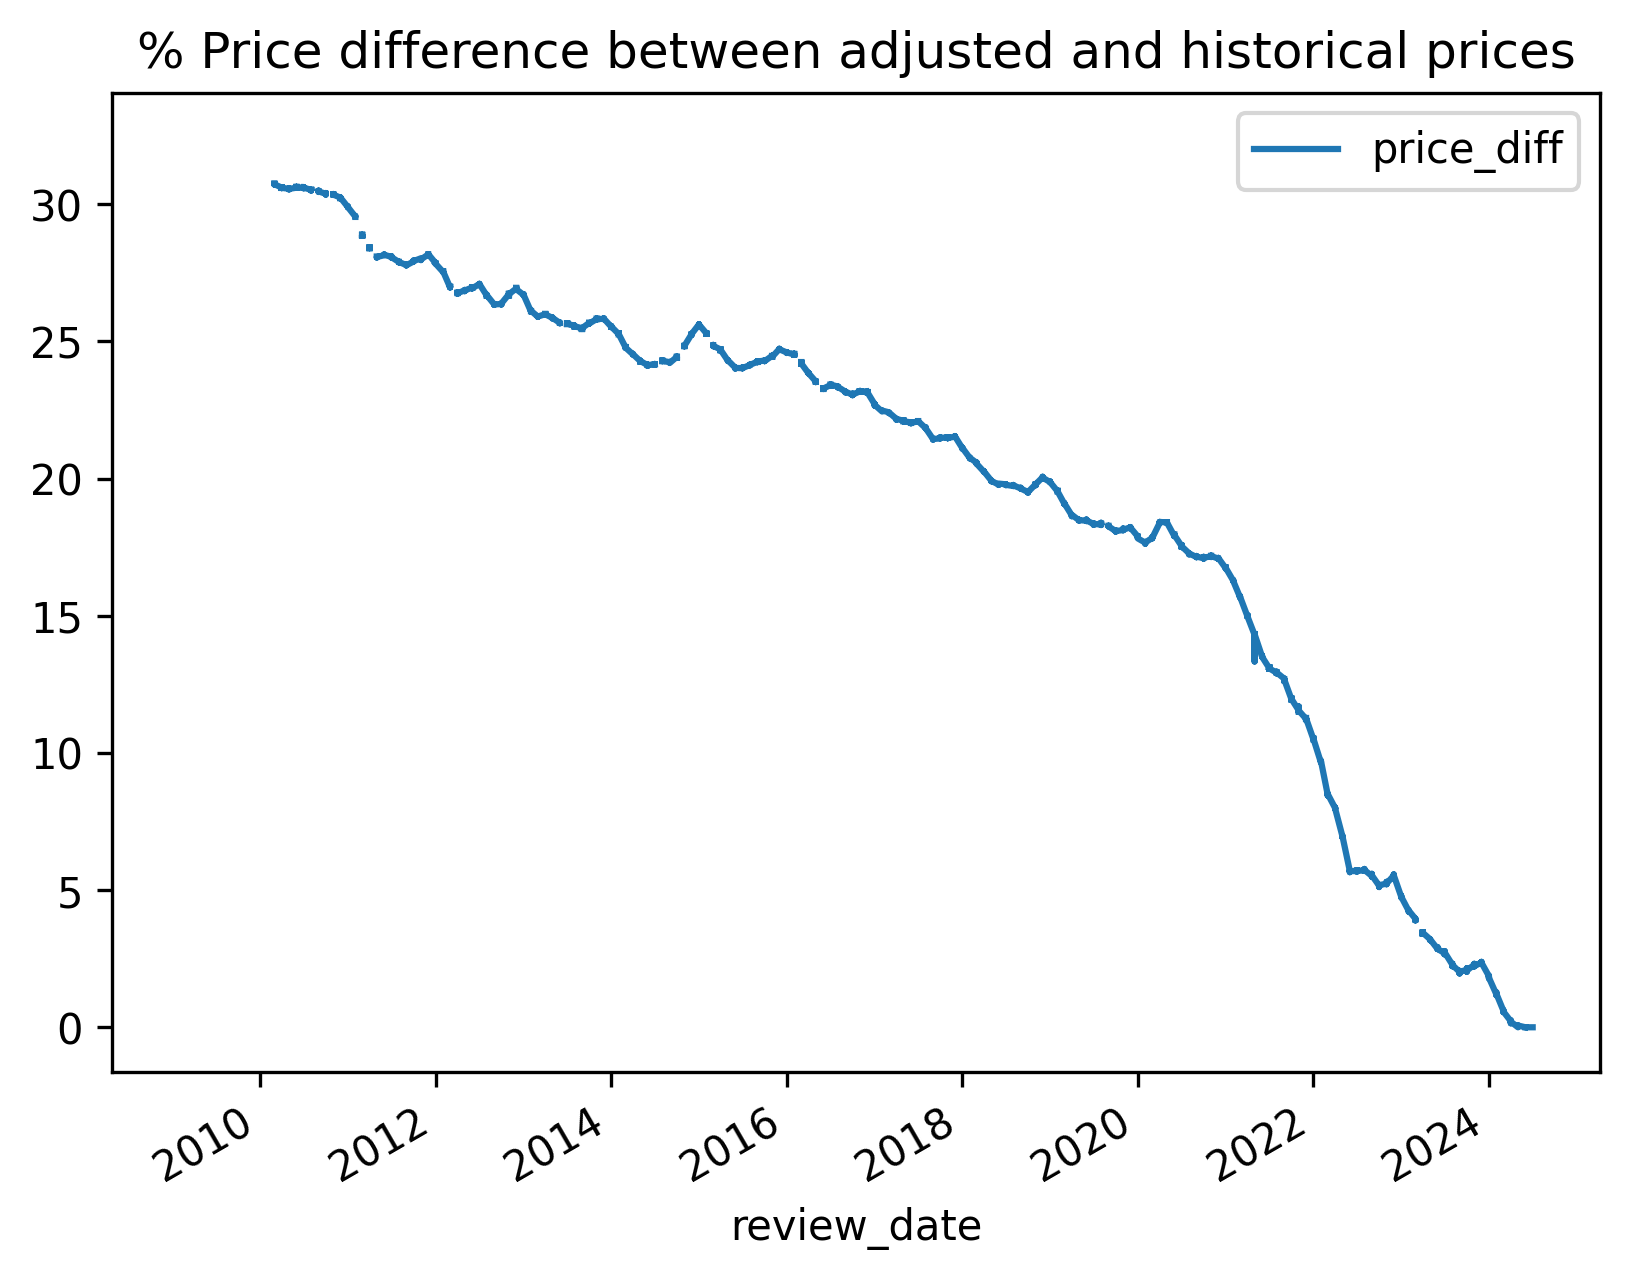

In [ ]:
# Plot the price difference between the adjusted and historical prices over time

(
    df.assign(
        price_diff=lambda df_: (df_["price_usd_adj"] - df_["price_usd"])
        / df_["price_usd_adj"]
        * 100
    ).sort_values("review_date")
).plot(
    x="review_date",
    y="price_diff",
    title="% Price difference between adjusted and historical prices",
)

### Create a column for $USD/lb using adjusted price 

In [ ]:
# Create a new column for price per pound
def price_per_lbs(df: pd.DataFrame) -> pd.DataFrame:
    df["price_usd_adj_per_lb"] = np.round(
        df["price_usd_adj"] / df["quantity_in_lbs"], 2
    )
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(clean_currency)
    .pipe(convert_currency)  # Convert to USD with historical exchange rates
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)  # Adjust for inflation
    .pipe(convert_to_lbs)  # Convert quantities to pounds
    .pipe(price_per_lbs)  # Calculate adjusted USD price per pound
)

df.head()

/var/folders/_b/62zrcmn50rvfx7ybj6pcf5380000gp/T/ipykernel_30053/2709149053.py:82: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),


,rating,roaster,title,blind_assessment,notes,bottom_line,roaster_location,coffee_origin,roast_level,est_price,review_date,aroma,acidity,body,flavor,aftertaste,url,with_milk,agtron_external,agtron_ground,is_espresso,quantity_value,quantity_unit,price_value,price_currency,price_usd,cpi,date,price_usd_adj,quantity_in_lbs,price_usd_adj_per_lb
0,92.0,Red Rooster Coffee Roaster,Ethiopia Sidama Shoye,"Rich, intricate and layered. Lemon zest, roasted cacao nib, violet, mulberry, frankincense in ar...",Produced by family-owned farms that are part of the Shoye Cooperative. This lot was processed by...,"An elegant washed Sidamo cup, both deeply sweet and delicately tart.","Floyd, Virginia","Sidamo (also Sidama) growing region, southern Ethiopia",Medium-Light,$14.49/12 ounces,2016-11-01,9.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ethiopia-sidama-shoye/,NaN,56.0,80.0,False,12.0,ounces,14.49,USD,14.49,241.353,2016-11-01,18.86,0.75,25.15
1,92.0,El Gran Cafe,Finca Santa Elisa Geisha,"Gently sweet-tart, crisply herbaceous. Baking chocolate, green grape, lemon verbena, fresh-cut o...","Produced by Finca Santa Elisa entirely of the Geisha variety of Arabica, and processed by the tr...","A confident, pretty washed-process Guatemala Geisha enlivened by crisp chocolate and sweet herb ...","Antigua, Guatemala","Acatenango growing region, Guatemala",Medium-Light,$30.00/12 ounces,2023-08-01,8.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/finca-santa-elisa-geisha/,NaN,62.0,78.0,False,12.0,ounces,30.00,USD,30.00,307.026,2023-08-01,30.70,0.75,40.93
2,93.0,Tipico Coffee,Costa Rica Sin Limites Gesha,"Floral-toned, tropical-leaning. Magnolia, guava, green banana, amber, cocoa nib in aroma and cup...","Produced by Jamie Cardenas of Finca Sin Limites, entirely of the Gesha variety of Arabica, and p...","A delicate honey-processed Costa Rica Gesha that evokes the tropics with its fruity profile, and...","Buffalo, New York","West Valley, Costa Rica",Light,$33.00/12 ounces,2024-06-01,9.0,9.0,8.0,9.0,8.0,https://www.coffeereview.com/review/costa-rica-sin-limites-gesha/,NaN,60.0,82.0,False,12.0,ounces,33.00,USD,33.00,314.175,2024-06-01,33.00,0.75,44.00
3,91.0,Roast House,Ride the Edge,"Crisply floral, delicately lively. Complex flowers – lavender, lilac – roasted cacoa nib, tanger...","The coffees in this blend are certified organically grown and Fair Trade, meaning they were purc...",NaN,"Spokane, Washington","Southern Ethiopia; Mexico; northern Sumatra, Indonesia.",Medium,$14.00/16 ounces,2015-07-01,8.0,8.0,8.0,9.0,8.0,https://www.coffeereview.com/review/ride-the-edge/,NaN,53.0,67.0,False,16.0,ounces,14.00,USD,14.00,238.654,2015-07-01,18.43,1.00,18.43
4,92.0,Level Ground Trading,Direct Fair Trade Espresso,"Evaluated as espresso. Intrigungly complex, balanced. Dark chocolate, molasses, cedar, narcissus...",Coffees in this blend are all fully wet-processed or “washed” and certified organically grown in...,A solid espresso blend equally pleasing as a straight shot and in milk.,"Victoria, British Columbia, Canada",Africa; South America,Medium-Light,CAD $17.00/16 ounces,2017-11-01,9.0,NaN,8.0,8.0,8.0,https://www.coffeereview.com/review/direct-fair-trade-espresso-2/,9,51.0,73.0,True,16.0,ounces,17.00,CAD,13.21,246.669,2017-11-01,16.83,1.00,16.83


# Coffee Origin Cleaning

In [ ]:
def get_standard_countries(
    add: list[str] | None = None, remove: list[str] | None = None
) -> set:
    """Return a modified list of country names from pycountry"""

    countries = set(unidecode(c.name.lower()) for c in pycountry.countries)

    if remove:
        for r in remove:
            try:
                countries.remove(r)
            except ValueError:
                continue

    for c in list(countries):
        if "(" in c:
            countries.remove(c)
            continue
        c_new: str = c.split(",")[0]
        countries.remove(c)
        countries.add(c_new)

    if add:
        for a in add:
            countries.add(a)
    return countries


standardized_countries: set[str] = get_standard_countries()

print(pd.Series(list(standardized_countries)).sort_values())

79           afghanistan
233        aland islands
91               albania
223              algeria
128       american samoa
             ...        
231    wallis and futuna
114       western sahara
195                yemen
98                zambia
90              zimbabwe
Length: 241, dtype: object


In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)


display(df.coffee_origin.sample(100))

# ";" means multiple
# "and" means multiple
# "undisclosed" means multiple
# "various" means multiple
# lowercase, strip whitespace
# remove punctuation, apostrophes
# hawaii, sanna, gedeo, kilimanjaro cleanup

2193                                 Yirgacheffe growing region, south-central Ethiopia.
6203                                                                         El Salvador
3367                                                                            Honduras
128     Lake Atitlan region of west-central Guatemala; northern Sumatra; southern Mexico
1174                            Harrar region of eastern Ethiopia; east Java, Indonesia.
3607                                                                      Not disclosed.
6471                                                       Quiche Department, Guatemala.
190                                                                       Not disclosed.
6454                                                 Tolima Department, central Colombia
1902                                                          La Union, Nariño, Colombia
5994                                          Kiambu growing region, south-central Kenya
1629                 

In [ ]:
def retrieve_countries(element: str, countries: set) -> str:
    countries_found: set = set()
    if pd.isna(element) or element == "":
        return ""
    for c in countries:
        if c in element:
            countries_found.add(c)
    if len(countries_found) == 0:
        return element
    # alphabetically sort the countries found
    countries_found = sorted(countries_found)
    return ";".join(countries_found)


def clean_origin(df: pd.DataFrame) -> pd.DataFrame:
    df = df.assign(coffee_origin=df.coffee_origin.str.lower())
    df["origin_country"] = df.coffee_origin.apply(
        retrieve_countries, countries=standardized_countries
    )
    return df


df = (
    df_in.pipe(tweak_df)
    .pipe(create_price_quantity_columns)
    .pipe(clean_currency)
    .pipe(convert_currency)
    .pipe(create_cpi_adjusted_price, file_path=cpi_path)
    .pipe(convert_to_lbs)
    .pipe(price_per_lbs)
    .pipe(clean_origin)
)

/var/folders/_b/62zrcmn50rvfx7ybj6pcf5380000gp/T/ipykernel_30053/2709149053.py:82: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  lambda df_: ~df_["quantity"].str.contains(drop_terms_string, case=False),


In [ ]:
df.origin_country.value_counts()

origin_country
ethiopia                                                                                            1345
colombia                                                                                             696
kenya                                                                                                621
guatemala                                                                                            446
indonesia                                                                                            371
not disclosed.                                                                                       369
panama                                                                                               310
costa rica                                                                                           309
                                                                                                     267
el salvador                             

# Export processed data

In [ ]:
file_out: Path = Path(f"{file_path_in.stem}_intermediate{file_path_in.suffix}")
file_path_out = DATA_DIR / "intermediate" / file_out
if not file_path_out.exists():
    raise FileNotFoundError(f"File {file_path_out} not found.")

df.to_csv(DATA_DIR / "intermediate" / file_path_out, index=False)